In [1]:
import numpy as np
def data_generate(num, dim, dist = 2.0, sigma = 1.0):
    x = np.zeros(shape = (num, dim,))
    y = np.zeros(shape = (num,))
    rand = np.random.rand(num)
    inds = rand < 0.2
    theta = np.zeros(shape = (dim,))
    theta[0] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.2, rand < 0.5)
    theta = np.zeros(shape = (dim,))
    theta[0] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.5, rand < 0.9)
    theta = np.zeros(shape = (dim,))
    theta[1] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    inds = rand >= 0.9
    theta = np.zeros(shape = (dim,))
    theta[1] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    return x, y
    

In [2]:
import cvxpy as cp
def erm_hinge(x, y):
    dim = x.shape[1]
    theta = cp.Variable(dim)
    intercept = cp.Variable()
    hinge = cp.sum(cp.pos(np.ones_like(y) - cp.multiply(y, cp.matmul(x, theta) + intercept * np.ones_like(y))))
    obj = cp.Minimize(hinge)
    prob = cp.Problem(obj,)
    prob.solve(solver = cp.GUROBI)
    return theta.value, intercept.value

In [3]:
import cvxpy as cp
def erm_sqhinge(x, y):
    dim = x.shape[1]
    theta = cp.Variable(dim)
    intercept = cp.Variable()
    sqhinge = cp.sum_squares(cp.pos(np.ones_like(y) - cp.multiply(y, cp.matmul(x, theta) + intercept * np.ones_like(y))))
    obj = cp.Minimize(sqhinge)
    prob = cp.Problem(obj,)
    prob.solve(solver = cp.GUROBI)
    return theta.value, intercept.value

In [4]:
import cvxpy as cp
def grad_sqhinge(x, y, theta, intercept):
    num = x.shape[0]
    dim = x.shape[1]
    grad = np.zeros(shape = (num, theta.shape[0] + 1,))
    inds = np.multiply(y, np.matmul(x, theta) + intercept) < 1.0
    grad[inds, :dim] = -np.einsum('i,ij->ij', 1.0 - np.multiply(y[inds], np.matmul(x[inds, :], theta) + intercept), np.einsum('i,ij->ij', y[inds], x[inds, :]))
    grad[inds, dim:] = -np.einsum('i,ij->ij', 1.0 - np.multiply(y[inds], np.matmul(x[inds, :], theta) + intercept), np.reshape(y[inds], (-1, 1)))
    return grad

def uncert(x, theta, intercept, mu = 1.0):
    return np.divide(1.0, 1.0 + mu * np.absolute(np.matmul(x, theta) + intercept))

def grad_equiv(x, y, theta, intercept, mu = 1.0):
    return np.average(np.einsum('i,ij->ij', uncert(x, theta, intercept, mu), grad_sqhinge(x, y, theta, intercept)), axis = 0)

def erm_equiv(x, y, mu = 1.0, tol = 1e-10, max_iter = 1e5, step_size = 1e-2, is_print = False, init = None):
    dim = x.shape[1]
    if init is None:
    # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    grad = grad_equiv(x, y, theta, intercept, mu)
    count = 0
    while np.linalg.norm(grad) > tol:
        theta -= grad[:dim] * step_size
        intercept -= grad[dim:] * step_size
        grad = grad_equiv(x, y, theta, intercept, mu)
        count += 1
        if is_print and count % 1000 == 0:
            print(count, np.linalg.norm(grad))
        if count > max_iter:
            print("max_iter")
            break
    return theta, intercept[0]

In [5]:
x, y = data_generate(num = 10000, dim = 2, dist = 2.0, sigma = 0.5)

In [7]:
theta_hinge, inter_hinge = erm_hinge(x, y)

In [8]:
theta_sqhinge, inter_sqhinge = erm_sqhinge(x, y)

In [9]:
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5)

1000 0.17114931098979363
2000 0.13802880311697274
3000 0.05877758678434084
4000 0.023706445313691094
5000 0.009998915332120505
6000 0.0043064484561715554
7000 0.001871172653916381
8000 0.0008164998027140045
9000 0.00035694876775935544
10000 0.0001561427177971442
11000 6.832247103849804e-05
12000 2.9900065687840396e-05
13000 1.3086090611885499e-05
14000 5.727439150057242e-06
15000 2.5067824045002327e-06
16000 1.0971733229481986e-06
17000 4.802141055608528e-07
18000 2.1018177496162425e-07
19000 9.199313127635658e-08
20000 4.0263899988723924e-08
21000 1.7622857018101917e-08
22000 7.713239769947166e-09
23000 3.3759604383666797e-09
24000 1.4776032253911945e-09
25000 6.467229601602258e-10
26000 2.830601700817586e-10
27000 1.238907781381692e-10


In [10]:
theta_eq1_05, inter_eq1_05 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 0.5)

1000 0.3228399597339838
2000 0.1381884576260792
3000 0.05077370375432956
4000 0.017087572713387775
5000 0.005823706785907961
6000 0.0019982139713724143
7000 0.000687018782306779
8000 0.00023638586375409904
9000 8.136144328694216e-05
10000 2.8006801998586756e-05
11000 9.64114046219016e-06
12000 3.3189594188984244e-06
13000 1.1425585110303888e-06
14000 3.933290120352751e-07
15000 1.354047391604297e-07
16000 4.6613517036429515e-08
17000 1.604685469143798e-08
18000 5.524182450229671e-09
19000 1.901717655661792e-09
20000 6.546728384973278e-10
21000 2.2537303938134228e-10


In [32]:
theta_eq1_01, inter_eq1_01 = erm_equiv(x, y, step_size=2e-3, is_print = True, max_iter = 1e5, mu = 0.1)

1000 0.004738454078631928
2000 0.0012482909022097492
3000 0.0003289058491307607
4000 8.666139309042261e-05
5000 2.283167393763018e-05
6000 6.015146054372679e-06
7000 1.5847334337403196e-06
8000 4.175098164117121e-07
9000 1.0999609664374309e-07
10000 2.897929976209978e-08
11000 7.63481499454459e-09
12000 2.0114495671457406e-09
13000 5.299314633700547e-10
14000 1.3961440797636986e-10


In [11]:
from tqdm import tqdm
def uncertain_sampling(x, y, mu = 1.0, max_iter = 1e6, step_size = 1e-3, init = None):
    num = x.shape[0]
    dim = x.shape[1]
    if init is None:
        # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    for count in tqdm(range(int(max_iter))):
        sample = np.random.randint(low=0, high=num)
        U = uncert(x[sample], theta, intercept, mu)
        tmp = np.random.rand()
        if tmp <= U:
            grad = grad_sqhinge(np.reshape(x[sample], (1, -1)), np.atleast_1d(y[sample]), theta, intercept).flatten()
            theta -= grad[:dim] * step_size
            intercept -= grad[dim:] * step_size
    return theta, intercept[0]

In [12]:
theta_us1, inter_us1 = uncertain_sampling(x, y, mu = 1.0, max_iter = 1e7, step_size = 1e-4)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [06:31<00:00, 25519.65it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


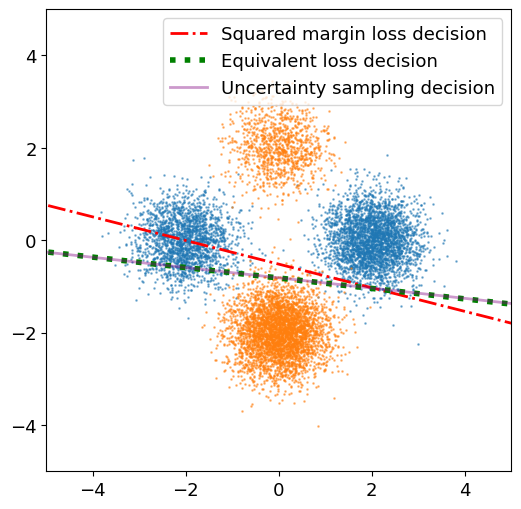

In [16]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 6))
inds = y == 1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'positive')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'negative')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
# hori_hinge = (-inter_hinge - theta_hinge[1] * vert_grid) / theta_hinge[0]
# plt.plot(hori_hinge, vert_grid, linestyle = 'dashed', label = 'Margin loss decision', color = 'olive', alpha = 1.0, linewidth = 2.0)
hori_sqhinge = (-inter_sqhinge - theta_sqhinge[1] * vert_grid) / theta_sqhinge[0]
plt.plot(hori_sqhinge, vert_grid, linestyle = 'dashdot', label = 'Squared margin loss decision', color = 'red', alpha = 1.0, linewidth = 2.0)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
# hori_eq1_05 = (-inter_eq1_05 - theta_eq1_05[1] * vert_grid) / theta_eq1_05[0]
# plt.plot(hori_eq1_05, vert_grid, linestyle = 'dashed', label = r'Equivalent loss decision, $\mu=0.5$', color = 'olive', alpha = 1.0)
# hori_eq1_01 = (-inter_eq1_01 - theta_eq1_01[1] * vert_grid) / theta_eq1_01[0]
# plt.plot(hori_eq1_01, vert_grid, linestyle = 'dashed', label = r'Equivalent loss decision, $\mu=0.1$', color = 'purple', alpha = 1.0)
hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.4, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.savefig("Experiment1-2.eps", bbox_inches='tight')
plt.savefig("Experiment1-2.jpg", bbox_inches='tight')
plt.show()